# 计算物理B第七次作业--第一题

PB20511896 王金鑫

### 题目描述

用随机森林求解伊辛模型

- 将测试、训练样本上预言正确率随训练样本占总样本比例的关系画出，训练样本比例区间为0.1%-90%
- 确定训练样本90%，测试10%，研究正确率随树木颗数、树木深度，以及叶子上最小样本数的关系，画图。最后给出最优超参选择

参考：https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB9_CVIII-randomforests_ising.html

数据集来源：https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/

> 其中每个数据为满足周期性边界条件的40x40个方形格点，由标准Metropolis算法生成。
> 
> 用0代表无序态，1代表有序态

### 数据集参数

In [1]:
import numpy as np

np.random.seed()  # shuffle random seed generator

# Ising model parameters
L = 40  # linear system size
J = -1.0  # Ising interaction
T = np.linspace(0.25, 4.0, 16)  # set of temperatures
T_c = 2.26  # Onsager critical temperature in the TD limit


### 加载数据集

In [2]:
import pickle
######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):

#DATA
# pickle reads the file and returns the Python object (1D array, compressed bits)
data = pickle.load(open('./Ising2DFM_reSample_L40_T=All.pkl', 'rb'))
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
# pickle reads the file and returns the Python object (here just a 1D array with the binary labels)
labels = pickle.load(open('./Ising2DFM_reSample_L40_T=All_labels.pkl', 'rb'))


### 划分数据

将数据划分为顺磁、临界附近和抗磁，从中随机抽取数据来形成训练集和测试集

这里将0.75的数据划为训练集，0.25的数据作为测试集

为方便，用X代表数据，用Y代表标签

In [3]:
###### define ML parameters
from sklearn.model_selection import train_test_split
# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
def load_data(X, Y, train_to_test_ratio):
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

    print('X_train shape:', X_train.shape)
    print('Y_train shape:', Y_train.shape)
    print()
    print(X_train.shape[0], 'train samples')
    print(X_critical.shape[0], 'critical samples')
    print(X_test.shape[0], 'test samples')

    return X_train, X_test, Y_train, Y_test


### 部分数据展示

从三类数据中各挑选一个来进行展示

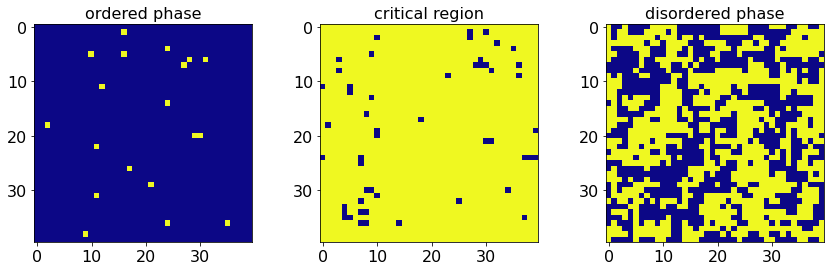

In [4]:
##### plot a few Ising states
%matplotlib inline 

import matplotlib.pyplot as plt

# set colourbar map
cmap_args=dict(cmap='plasma_r')
# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[60001].reshape(L,L),**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[5001].reshape(L,L),**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[45001].reshape(L,L),**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

### 使用随机森林进行训练和测试

其中，
- 使用GINI系数来衡量损失
- 取树的数量为10~100
- 取两种叶子所能包含的最小的样本量：2和5000，来进行两种不同精细程度的划分
- 给出运行时间、在不同数据集上的准确度，以及袋外(out-of-bag)准确度

In [5]:
# Apply Random Forest

#This is the random forest classifier
from sklearn.ensemble import RandomForestClassifier


#import time to see how perforamance depends on run time
import time

import warnings
#Comment to turn on warnings
warnings.filterwarnings("ignore")

#We will check 

min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier

print_flag=True


### 训练及结果

以下分别为两个小题的结果

#### 第一小题

准确率随训练样本比例的变化

train_to_test_ratio: 0.0010, leaf_size: 5
X_train shape: (130, 1600)
Y_train shape: (130,)

130 train samples
30000 critical samples
129870 test samples
time (s)       train score    OOB estimate   test score     critical score 
0.0747         1.0000         0.9923         0.9993         0.9221         
train_to_test_ratio: 0.1010, leaf_size: 5
X_train shape: (13130, 1600)
Y_train shape: (13130,)

13130 train samples
30000 critical samples
116870 test samples
time (s)       train score    OOB estimate   test score     critical score 
0.6388         0.9989         0.9957         0.9993         0.9221         
train_to_test_ratio: 0.2010, leaf_size: 5
X_train shape: (26130, 1600)
Y_train shape: (26130,)

26130 train samples
30000 critical samples
103870 test samples
time (s)       train score    OOB estimate   test score     critical score 
1.3392         0.9992         0.9957         0.9993         0.9221         
train_to_test_ratio: 0.3010, leaf_size: 5
X_train shape: (39130, 1600)
Y_

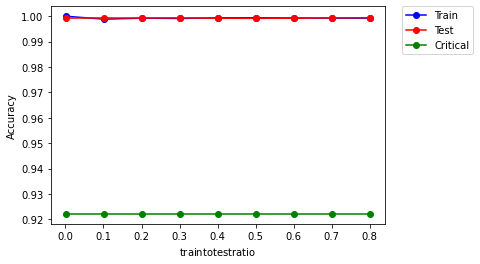

In [6]:

train_to_test_ratios = np.arange(0.001, 0.9, 0.1)  # training samples
leaf_size = 5
n=len(train_to_test_ratios)

# Define Random Forest Classifier
myRF_clf = classifer(
    n_estimators=min_estimators,
    max_depth=None,
    min_samples_split=5,  # minimum number of sample per leaf
    oob_score=True,
    random_state=0,
    warm_start=True  # this ensures that you add estimators without retraining everything
)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros(n)
RFC_train_accuracy=np.zeros(n)
RFC_test_accuracy=np.zeros(n)
RFC_critical_accuracy=np.zeros(n)
run_time=np.zeros(n)

for i, train_to_test_ratio in enumerate(train_to_test_ratios):

    print('train_to_test_ratio: %.4f, leaf_size: %i' %
          (train_to_test_ratio, leaf_size))
    
    X_train, X_test, Y_train, Y_test = load_data(X, Y, train_to_test_ratio)

    start_time = time.time()
    myRF_clf.set_params(n_estimators=50)
    myRF_clf.set_params(min_samples_split=leaf_size)
    myRF_clf.fit(X_train, Y_train)
    run_time[i] = time.time() - start_time

    # check accuracy
    RFC_train_accuracy[i]=myRF_clf.score(X_train,Y_train)
    RFC_OOB_accuracy[i]=myRF_clf.oob_score_
    RFC_test_accuracy[i]=myRF_clf.score(X_test,Y_test)
    RFC_critical_accuracy[i]=myRF_clf.score(X_critical,Y_critical)
    if print_flag:
        result = (run_time[i], RFC_train_accuracy[i], RFC_OOB_accuracy[i], RFC_test_accuracy[i], RFC_critical_accuracy[i])
        print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
        print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))

##############################

plt.figure()

# Accuracy
plt.plot(train_to_test_ratios, RFC_train_accuracy, 'o-b', label='Train')
plt.plot(train_to_test_ratios, RFC_test_accuracy, 'o-r', label='Test')
plt.plot(train_to_test_ratios,
         RFC_critical_accuracy, 'o-g', label='Critical')

plt.xlabel('$\mathrm{train to test ratio}$')
plt.ylabel('Accuracy')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig("Ising_RF.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


#### 第二小题

准确率随叶子上最小样本数及树木棵数的变化

X_train shape: (117000, 1600)
Y_train shape: (117000,)

117000 train samples
30000 critical samples
13000 test samples
n_estimator: 10, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
8.5483         1.0000         0.9936         1.0000         0.7981         
n_estimator: 20, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
9.9009         1.0000         0.9999         1.0000         0.8069         
n_estimator: 30, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
10.9873        1.0000         1.0000         1.0000         0.8073         
n_estimator: 40, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
12.2118        1.0000         1.0000         1.0000         0.8097         
n_estimator: 50, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
12.8744        1.0000         1.0000      

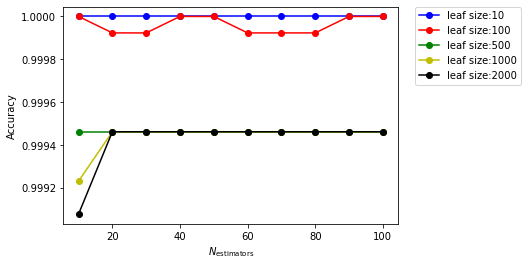

In [16]:


n_estimator_range = np.arange(min_estimators, max_estimators, 10)
leaf_sizes = [10,100,500,1000,2000]
n=len(n_estimator_range)
m=len(leaf_sizes)


#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((m,n))
RFC_train_accuracy=np.zeros((m,n))
RFC_test_accuracy=np.zeros((m,n))
RFC_critical_accuracy=np.zeros((m,n))
run_time = np.zeros((m, n))

train_to_test_ratio = 0.9
X_train, X_test, Y_train, Y_test = load_data(X, Y, train_to_test_ratio)

for i, leaf_size in enumerate(leaf_sizes):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None,
        min_samples_split=leaf_size,  # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True  # this ensures that you add estimators without retraining everything
    )
    
    for j, n_estimator in enumerate(n_estimator_range):
        print('n_estimator: %i, leaf_size: %i' %
            (n_estimator, leaf_size))

        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

        # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))

##############################

plt.figure()

# Accuracy
plt.plot(n_estimator_range,
         RFC_test_accuracy[0], 'o-b', label=f'leaf size:{leaf_sizes[0]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[1], 'o-r', label=f'leaf size:{leaf_sizes[1]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[2], 'o-g', label=f'leaf size:{leaf_sizes[2]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[3], 'o-y', label=f'leaf size:{leaf_sizes[3]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[4], 'o-k', label=f'leaf size:{leaf_sizes[4]}')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig("Ising_RF.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()



准确率随树木最大深度及数目棵数的变化

n_estimator: 10, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
6.1161         0.9993         0.9852         0.9992         0.7989         
n_estimator: 20, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
6.7994         0.9993         0.9984         0.9993         0.8025         
n_estimator: 30, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
7.9427         0.9993         0.9992         0.9993         0.8033         
n_estimator: 40, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
9.2918         0.9993         0.9993         0.9993         0.8035         
n_estimator: 50, leaf_size: 10
time (s)       train score    OOB estimate   test score     critical score 
10.1306        0.9993         0.9993         0.9993         0.8045         
n_estimator: 60, leaf_size: 10
time (s)       train score    OOB estimate   test scor

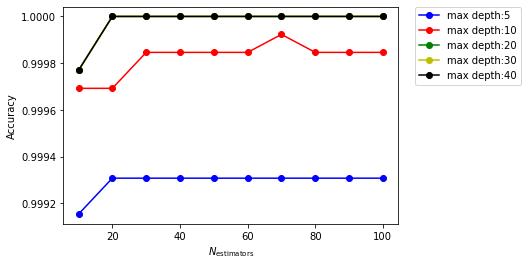

In [15]:
n_estimator_range = np.arange(min_estimators, max_estimators, 10)
max_depthes = [5,10,20,30,40]
m=len(max_depthes)
leaf_size = 10

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((m,n))
RFC_train_accuracy=np.zeros((m,n))
RFC_test_accuracy=np.zeros((m,n))
RFC_critical_accuracy=np.zeros((m,n))
run_time = np.zeros((m, n))

for i, max_depth in enumerate(max_depthes):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=max_depth,
        min_samples_split=leaf_size,  # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True  # this ensures that you add estimators without retraining everything
    )

    for j, n_estimator in enumerate(n_estimator_range):
        print('n_estimator: %i, leaf_size: %i' %
            (n_estimator, leaf_size))

        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

        # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))

##############################

plt.figure()
# Accuracy
plt.plot(n_estimator_range,
         RFC_test_accuracy[0], 'o-b', label=f'max depth:{max_depthes[0]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[1], 'o-r', label=f'max depth:{max_depthes[1]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[2], 'o-g', label=f'max depth:{max_depthes[2]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[3], 'o-y', label=f'max depth:{max_depthes[3]}')
plt.plot(n_estimator_range,
         RFC_test_accuracy[4], 'o-k', label=f'max depth:{max_depthes[4]}')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig("Ising_RF.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


综上结果可知最优超参数选择可取：
- 叶子上最小样本数为10
- 树木最大深度为20
- 树木棵树为20

In [ ]:
# DataChosen = X_test[10020]

# plt.imshow(DataChosen.reshape(L, L), **cmap_args)
# plt.show()

# result = myRF_clf.predict_proba([DataChosen])
# print("{0:<15}{1:<15}".format("P(disordered)", "P(ordered)"))
# print("{0:<15.4f}{1:<15.4f}".format(*result[0]))
